# COGS 108 - Final Project 

# Overview

*Fill in your overview here*

# Names

- Samvit Sutodiya
- Arya Nair
- Linwei Lu
- Jenny Zhang

# Group Members IDs

- A########
- A########
- A13996537
- A14854801

# Research Question

Does the amount of Medicare one receives for a specific illness differ from state to state based on the state’s population?

## Background and Prior Work

Medicare is a national health insurance program that covers health care costs for adults over the age of 65 and younger people with specific disabilities. Medicare has four parts that help cover certain services such as Hospital Insurance, Medical Insurance, prescription drug coverage and a Medicare Advantage which is an all in one plan. The main benefit of Medicare is that it provides health coverage regardless of the person’s income, thus benefiting people with low income by helping those who are unable to afford medical insurance (“Acute Inpatient PPS”, 2019).

But unfortunately this isn’t always the case. Studies such as ‘Medicare Utilization in the United States: PSRO and Regional Impacts’ by DL Rothberg, J Pinto and PM Gertman show how geographical factors affect medicare in the United States. Factors such as demographic and socio-economics play a role in determining the amount of medicare one receives. In this project we explore how population plays a role in determining the amount of medicare one receives. 

References (include links):
- 1) “Acute Inpatient PPS”, 2019 (https://www.cms.gov/Medicare/Medicare-Fee-for-Service-Payment/AcuteInpatientPPS/index.html?redirect=/AcuteInpatientPPS/)
- 2) ‘Medicare Utilization in the United States: PSRO and Regional Impacts’ by DL Rothberg, J Pinto and PM Gertman (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1072167/)

# Hypothesis


The question our project asks is whether the amount of medicare one receives for a specific illness, differs from state to state based on the state’s population. The amount of medicare is calculated as the ratio of amount covered by medicare to the amount paid by patients. 

The hypothesis we have is that the greater the population of the state, the more medicare one receives on average.


# Datasets- Description

In this project, we utilize three Datasets: one relating to the medical insurance and two involving the state population details. Given on these three data sets, we would able to found out "whether the amount of medicare one receives for a specific illness, differs from state to state based on the state’s population"(project proposal). 

First dataset we will involve is the "Inpatient Prospective Payment System (IPPS) Provider Summary for the Top 100 Diagnosis-Related Groups (DRG) - FY2011". The Inpatient Prospective Payment System(MIPPS) is a payment system for inpatient care and stays covered by medical insurance (Medicare). The data table includes Total Discharges, Average Covered Discharges, Average Total Payments, and Average Medicare Payments which help extract the amount of Medicare provided for a specific illness. what's more, the data set provides over 3,000 u.s hospitals spefical charges information, and top 100 most frequently billed discharges involving with the MIPPS payments. In the columns of the dataset, it involves DRG to represents over "7 million discharges or 60 percent of totalMedicare IPPS discharges". It classifies the system grouping similar clinical conditions and procedures and the provider city. Hence, the said data tables help us to answer the question of how much the patients pay for the different illness in each state.

- DataSet Name: "Inpatient Prospective Payment System (IPPS) Provider Summary for the Top 100 Diagnosis-Related Groups (DRG) - FY2011".
- Link to the dataset: https://data.cms.gov/Medicare-Inpatient/Inpatient-Prospective-Payment-System-IPPS-Provider/97k6-zzx3
- Data Provided by CMs, DataSet Owner OEDA
- Number of observations: 163065

Second dataset we included is the "National, State, and Puerto Rico Commonwealth Totals Datasets: Population, population change, and estimated components of population change: April 1, 2010 to July 1, 2018". It is provided by United States Census Bureau. This dataset contains data from the 2010 US Census, as well as estimated yearly population, population change, and estimated components of population change of each state from 2010-2018.In the columns of table, it includes Name of the Region, Popluation Estimate ,National Population Change, Birth Rate, Death Rate, which provides the conprehensive information of the population changes in demestic and national scales. 

- DataSet Name:"National, State, and Puerto Rico Commonwealth Totals Datasets: Population, population change, and estimated components of population change: April 1, 2010 to July 1, 2018". 
- Link to the dataset: https://www.census.gov/data/datasets/time-series/demo/popest/2010s-state-total.html 
- Data Provided by United States Census Bureau
- Number of observations: 57


The third one is "CSV of States and State Abbreviations", provided by fronz.net weblog. This dataset contains all the US states and their abbreviation.Unlike the said two datasets, this dataset table is straightforward: there are only two columnes: State name and Abbreviation. This dataset  increase the efficency to recognize, categorize and label the geographic information.

- DataSet Name: "CSV of States and State Abbreviations".
- Link to the dataset: http://www.fonz.net/blog/archives/2008/04/06/csv-of-states-and-state-abbreviations/
- Number of observations: 51

In conculsion, We plan to combine these three databases by adding the populations for each provider state to analyze whether the population of a state affects the amount of Medicare one receives. Since the first dataset uses state abbreviations while the census uses their names, we will be using a third dataset to match abbreviations to state names. 

# Setup

In [1]:
import pandas as pd

# Data Cleaning

Describe your data cleaning steps here.

First, we will read in the dataset.

In [2]:
df = pd.read_csv('Inpatient_Prospective_Payment_System__IPPS__Provider_Summary_for_the_Top_100_Diagnosis-Related_Groups__DRG__-_FY2011.csv')

Next, we will drop the columns that we won't be using in our analysis, which are all the provider-related fields (aside from the state) and the hospital region. Some of the column names have extra spaces around them, so we will rename those columns.

In [3]:
df.drop(columns = ['Provider Id', 'Provider Name', 'Provider Street Address', 
                   'Provider City', 'Provider Zip Code', 'Hospital Referral Region Description'],
                 inplace = True)
columns = ['DRG Definition', 'State', 'Total Discharges', 'Average Covered Charges',
           'Average Total Payments', 'Average Medicare Payments']
df.columns = columns

Next, we need to combine all the data for each state. We will be analyzing different illnesses/conditions separately, so each state will have one row for each illness containing the Average Covered Charges (the provider's average charge for services) and Average Medicare Payments (the amount covered by Medicare, not including co-payment and deductibles). We will keep the Total Payments column as well, in case we want to analyze it separately later. Using the number of total discharges from each hospital, we will calculate each of these average amounts for each illness within each state.

Using these average values, we will create two new dataframes to perform analysis on. The first dataframe will contain the average amounts for each state and condition. The second dataframe will only contain the average values for each state, for the purpose of simplifying our overall analysis.

In [4]:
# construct the rows of the first dataframe, separated by condition and state
rows_condition = list()
for name, group in df.groupby(['State', 'DRG Definition']):
    total_discharges = group['Total Discharges'].sum()
    avg_charges = (group['Average Covered Charges'] * group['Total Discharges']).sum() / total_discharges
    avg_total = (group['Average Total Payments'] * group['Total Discharges']).sum() / total_discharges
    avg_medicare = (group['Average Medicare Payments'] * group['Total Discharges']).sum() / total_discharges
    rows_condition.append([name[1], name[0], total_discharges, avg_charges, avg_total, avg_medicare])

# construct the rows of the second dataframe, separated by state
rows_state = list()
for name, group in df.groupby(['State']):
    total_discharges = group['Total Discharges'].sum()
    avg_charges = (group['Average Covered Charges'] * group['Total Discharges']).sum() / total_discharges
    avg_total = (group['Average Total Payments'] * group['Total Discharges']).sum() / total_discharges
    avg_medicare = (group['Average Medicare Payments'] * group['Total Discharges']).sum() / total_discharges
    rows_state.append([name, total_discharges, avg_charges, avg_total, avg_medicare])
    
df_condition = pd.DataFrame(rows_condition, columns = columns)
df_state = pd.DataFrame(rows_state, columns = ['State', 'Total Discharges', 'Average Covered Charges',
                                     'Average Total Payments', 'Average Medicare Payments'])

Our df_condition dataframe currently contains data for the top 100 Diagnosis-Related Groups (DRG). To simplify our analysis, we will narrow down our data to the top 10 DRG, based on number of total discharges.

In [5]:
rows_DRG = list()
for name, group in df.groupby(['DRG Definition']):
    rows_DRG.append([name, group['Total Discharges'].sum()])
df_DRG = pd.DataFrame(rows_DRG, columns = ['DRG Definition', 'Total Discharges'])
top = df_DRG.nlargest(10, 'Total Discharges')['DRG Definition']
df_condition = df_condition[df_condition['DRG Definition'].isin(top)]

Next, we will read in the state population dataset. The population dataset uses the full names of states, but our Medicare dataset uses their abbreviations. To match populations with states, we will use a third dataset containing the abbreviations of states to add the abbreviations to the population dataset.

In [6]:
df_population = pd.read_csv('nst-est2018-alldata.csv')
df_states = pd.read_csv('states.csv')

# drop all columns except the two necessary columns
df_population = df_population[['NAME', 'POPESTIMATE2018']]

# rename the columns to merge with df_states
df_population.columns = ['State', 'Population']
df_population = df_population.merge(df_states, on='State')

# rename the columns again to merge with Medicare dataframes
df_population.drop(columns = ['State'], inplace = True)
df_population.columns = ['Population', 'State']

df_condition = df_condition.merge(df_population, on='State')
df_state = df_state.merge(df_population, on='State')

Finally, we will add a column for the ratio of the amount covered by medicare to the total charges from the provider.

In [7]:
df_state['Average % Covered'] = df_state['Average Medicare Payments'] / df_state['Average Covered Charges']
df_condition['Average % Covered'] = df_condition['Average Medicare Payments'] / df_condition['Average Covered Charges']

# Data Analysis & Results

Include cells that describe the steps in your data analysis.

Set up

In [23]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (17, 7) 
import seaborn as sns
sns.set(style='white', font_scale=2) 
from scipy.stats import uniform, norm, bernoulli, poisson

In [25]:
df_state.head()

,State,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,Population,Average % Covered
0,AK,6142,42951.966272,14677.608214,12863.920692,737438,0.299496
1,AL,142704,32087.949258,7698.639995,6507.089416,4887871,0.202789
2,AR,86769,25256.135506,7865.409244,6736.541744,3013825,0.266729
3,AZ,104604,39461.670988,9785.859172,8431.946484,7171646,0.213674
4,CA,474979,66541.572710,12342.045516,11189.278296,39557045,0.168155


In [31]:
df_condition.head()

,DRG Definition,State,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,Population,Average % Covered
0,190 - CHRONIC OBSTRUCTIVE PULMONARY DISEASE W MCC,AK,163,34448.242331,12877.468712,11592.640368,737438,0.336523
1,194 - SIMPLE PNEUMONIA & PLEURISY W CC,AK,320,24127.703344,10791.338313,9800.009219,737438,0.406172
2,291 - HEART FAILURE & SHOCK W MCC,AK,111,49619.668919,15952.139910,15118.112883,737438,0.304680
3,292 - HEART FAILURE & SHOCK W CC,AK,217,32059.638157,11119.028756,9517.678111,737438,0.296874
4,"392 - ESOPHAGITIS, GASTROENT & MISC DIGEST DIS...",AK,210,19374.429286,7745.519619,6451.919333,737438,0.333012


Content:
It shows up all the overall averages for each state

The reason:
1. Match the state with analysis data
2. Prepare for the visualization
3. Clear up the useless data

SIZE

In [32]:
df_state.shape

(51, 7)

In [33]:
df_condition.shape

(510, 8)

Reason:
1. Give the overview of the information you have
2. Check whether the data has read into the Python in the right way
3. Determine the appropriation of the analyses

MISSING

In [99]:
S_rows = df_state.isnull().any(axis=1)
df_state[rows].shape

(0, 7)

In [100]:
C_rows = df_condition.isnull().any(axis=1)
df_condition[C_rows].shape

(0, 8)

Reason:
1. Make sure no value missing
2. Missing value could happen randomly

In [101]:
df_state.columns[df_state.isnull().any(axis=0)]

Index([], dtype='object')

In [102]:
df_condition.columns[df_state.isnull().any(axis=0)]

/opt/conda/lib/python3.6/site-packages/pandas/core/indexes/base.py:2095: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 8 but corresponding boolean dimension is 7
  result = getitem(key)


Index([], dtype='object')

In [103]:
df_state.isnull().sum()

State                        0
Total Discharges             0
Average Covered Charges      0
Average Total Payments       0
Average Medicare Payments    0
Population                   0
Average % Covered            0
dtype: int64

In [104]:
df_state.isnull().sum()

State                        0
Total Discharges             0
Average Covered Charges      0
Average Total Payments       0
Average Medicare Payments    0
Population                   0
Average % Covered            0
dtype: int64

MEDIAA, MEAA, RANGE

In [105]:
df_state.median()

Total Discharges             9.625800e+04
Average Covered Charges      2.997421e+04
Average Total Payments       9.577254e+03
Average Medicare Payments    8.192004e+03
Population                   4.468402e+06
Average % Covered            2.833274e-01
dtype: float64

In [106]:
df_condition.median()

Total Discharges             2.803000e+03
Average Covered Charges      2.212252e+04
Average Total Payments       7.185075e+03
Average Medicare Payments    6.135001e+03
Population                   4.468402e+06
Average % Covered            2.801941e-01
dtype: float64

In [107]:
df_state.mean()

Total Discharges             1.367709e+05
Average Covered Charges      3.172170e+04
Average Total Payments       9.820840e+03
Average Medicare Payments    8.473373e+03
Population                   6.415048e+06
Average % Covered            2.895403e-01
dtype: float64

In [108]:
df_condition.mean()

Total Discharges             4.426737e+03
Average Covered Charges      2.644126e+04
Average Total Payments       8.382098e+03
Average Medicare Payments    7.222726e+03
Population                   6.415048e+06
Average % Covered            2.954297e-01
dtype: float64

In [128]:
s_max=df_state['Average % Covered'].max()
s_min=df_state['Average % Covered'].min()
s_range= s_max-s_min
print(s_max,'-',s_min,'=',s_range)

s_max1=df_state['Total Discharges'].max()
s_min1=df_state['Total Discharges'].min()
s_range1= s_max1-s_min1
print(s_max1,'-',s_min1,'=',s_range1)

0.853637203027 - 0.143389603028 = 0.710247599999
536859 - 6142 = 530717


IQR(interquartile Range)

In [130]:
low, up = np.percentile(df_state['Total Discharges'], [0,100])
low, up

(6142.0, 536859.0)

In [131]:
iqr = up - low
iqr

530717.0

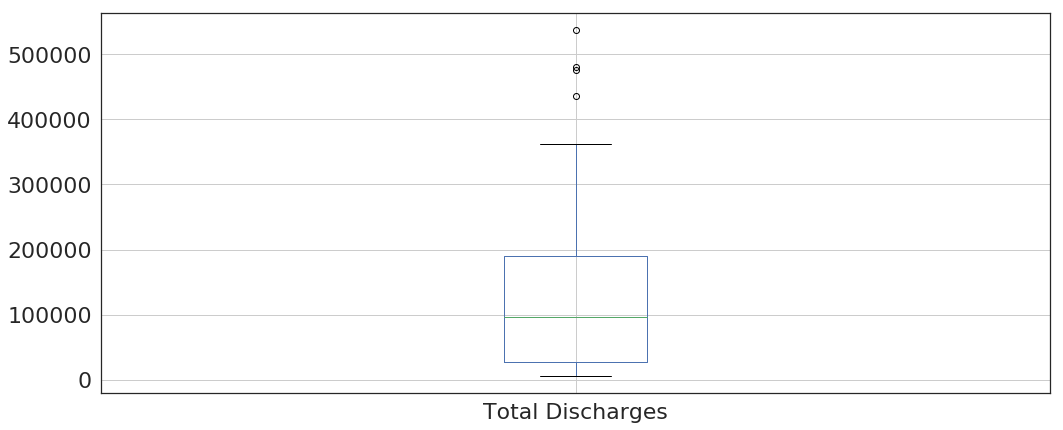

In [132]:
df_state.boxplot(column='Total Discharges');

In [114]:
df_state.describe()

,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,Population,Average % Covered
count,51.000000,51.000000,51.000000,51.000000,5.100000e+01,51.000000
mean,136770.941176,31721.703026,9820.840340,8473.372951,6.415048e+06,0.289540
std,136373.001344,9883.227277,1455.670820,1353.143741,7.343308e+06,0.107716
min,6142.000000,12526.838236,7698.639995,6507.089416,5.777370e+05,0.143390
25%,27672.000000,26036.436405,8690.971388,7421.887800,1.780020e+06,0.234108
50%,96258.000000,29974.207598,9577.254318,8192.004130,4.468402e+06,0.283327
75%,190153.500000,33471.699913,10438.062550,8971.237964,7.353618e+06,0.324085
max,536859.000000,66541.572710,14677.608214,12863.920692,3.955704e+07,0.853637


In [115]:
df_condition.describe()

,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,Population,Average % Covered
count,510.000000,510.000000,510.000000,510.000000,5.100000e+02,510.000000
mean,4426.737255,26441.257100,8382.098266,7222.726177,6.415048e+06,0.295430
std,4902.784534,13718.437845,3511.466525,3244.881417,7.278097e+06,0.112333
min,80.000000,7083.192407,4040.240772,3079.473446,5.777370e+05,0.115372
25%,853.500000,16659.332012,5920.051488,4891.713484,1.754208e+06,0.230998
50%,2803.000000,22122.518814,7185.074704,6135.001326,4.468402e+06,0.280194
75%,6122.750000,32780.892360,10480.887518,9491.254150,7.535591e+06,0.333011
max,34284.000000,90122.480767,21160.936960,18645.465059,3.955704e+07,0.886906


In [112]:
dis1= np.random.normal(6, 3, 1000)
dis2= np.random.normal(6, 8, 1000)

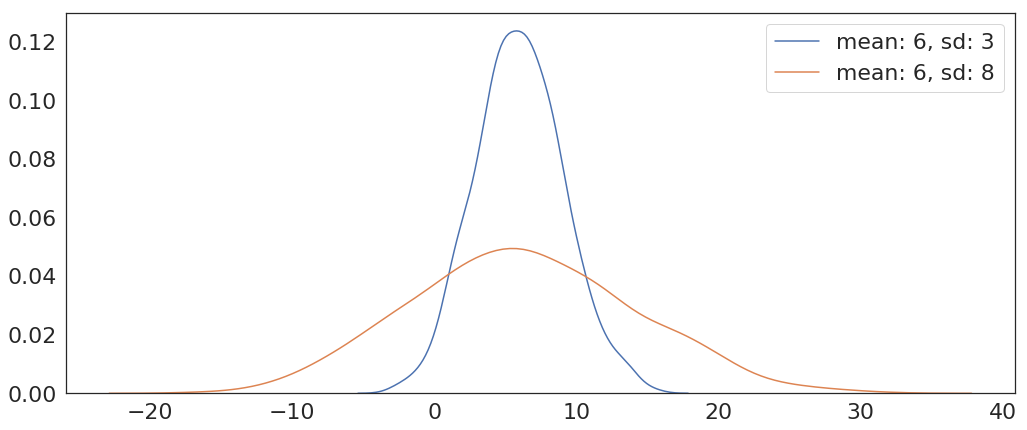

In [83]:
sns.kdeplot(dis1, label="mean: 6, sd: 3")
sns.kdeplot(dis2, label="mean: 6, sd: 8")
plt.legend();

# Ethics & Privacy

The stakeholders in the hypothesis we are investigating include medical insurance companies and people who receive medicare. It is unlikely that the information we will gain could be co-opted for nefarious purposes. The data we are using is collected from across over 3,000 U.S. hospitals that received Medicare payments, where the information is limited to the locations of the hospital and the provider and the amount covered. The patients’ data is kept anonymous.

Before we analyze the dataset, we make sure all the resource has permission fromt the owner. In the Dataset Description part, we knowledge each dataset's owner and website to ensure they get the credits for their contribution. All the information that we used in this project is open sources. In other owrds, it is free for all the people to access to reengage with the coding or data structure. 

The privacy concerns are related to the patients' information in the first data. It may have the potential bias when the data information are classified by diseases: the developers of dataset or we may involve with the personal feeling, which can cause the unfair outcome. However, overall, I think this dataset should be a fine for us to apply in those follwoing reasons. From our prespective, as we mentioned previsouly, the recognizable personal informaiton is anonymous. 

It means that althought we are able to access the disease and payment details, we can't identify the person. Hence, it would not lead to the issues of　invasion privacy. We would able to deal with the dataset without bias. First data set  "Inpatient Prospective Payment System (IPPS) Provider" is provided by the website called 'Data.Cvs.gov':'A federal government website managed by the Centers for Medicare & Medicaid Services'. In this case, the data and information are collected by the perfessonal government center, which shows certain reliability and trustworty of the information sources. It should be past through in the legit way.  

Hence, the data could be served in education purpose and to inform the public. Given on that situation, I think the first dataset would allow us to apply those data information with equitable analysis. 

In the second dataset, it involves with population, Birth Rate, Death Rate and Common wealth in each states.Compared to the first dataset, it is less personal targeting but more overall states' situation. Hence, it would allow us to deeply analyze and respect the datas collected by each states' governments. It didn't target to any specific class, race or gender. Indeed, there are still potential biases: in this case, we can't guarantee that each state government would report the accurate data, when it comes with the change of population. The accuracy of postestimate population could be affected by the serveral factors: such as the undocumented people or human trafficking etc. 

This may lead to the potential biases because the dataset of popluation can't and didn't include these marginalized groups of people into considerations. Hence, the dataset of population change may fully reflect the real world situtaion in each states. These issues are out of our capability to handle and can't solved by us; Therefore, we acknownledge thess potential biases in the Ethics & Privacy section to present our thinking and concerns to these groups of people.

The third dataset are more like the commonsense hence it does not involve with the privacy issues or potential biases.

# Conclusion & Discussion

*Fill in your discussion information here*